# 📈 LSTM Prediction Prototype
This notebook demonstrates a simple LSTM model to forecast stock returns using live market data and news volume.

We will:
1. Load price and news data
2. Create features from returns and news mentions
3. Train an LSTM model to predict next-step returns
4. Evaluate predictions


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import pyarrow.parquet as pq
import pyarrow as pa
from pathlib import Path


In [30]:
# Load historical price and news data from parquet
data_dir = (Path.cwd().parent / "src" / "data").resolve()
ticker = 'GOOGL'

# Read price data
prices = pd.read_parquet(data_dir / "prices.parquet")
prices = prices[prices['ticker'] == ticker].copy()
prices['timestamp'] = pd.to_datetime(prices['timestamp'])
prices.set_index('timestamp', inplace=True)

# Compute returns
prices['return'] = prices['price'].pct_change()

# --- Load News Data ---
mentions = pd.read_parquet(data_dir / "ticker_mentions.parquet")
articles = pd.read_parquet(data_dir / "news_articles.parquet")

# Merge to get timestamps for ticker mentions
mentions = mentions.merge(articles[['article_id', 'timestamp']], on='article_id', how='left')
mentions = mentions[mentions['ticker'] == ticker].copy()
mentions['timestamp'] = pd.to_datetime(mentions['timestamp'])
mentions.set_index('timestamp', inplace=True)

# Resample and align
mentions = mentions.resample('1min').size().rename("mentions").to_frame()
prices = prices.resample('1min').last().dropna()

# Merge
data = pd.merge(prices[['return']], mentions, left_index=True, right_index=True)
data = data.dropna()
data.tail()

,return,mentions
timestamp,,
2025-07-28 19:56:00,0.000026,0
2025-07-28 19:57:00,0.000026,3
2025-07-28 19:58:00,0.000000,1
2025-07-28 19:59:00,0.000052,3
2025-07-28 20:20:00,0.000312,1


In [31]:
# Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# Create sequences
SEQ_LEN = 10
X, y = [], []
for i in range(SEQ_LEN, len(scaled)):
    X.append(scaled[i-SEQ_LEN:i])
    y.append(scaled[i][0])

X, y = np.array(X), np.array(y)
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

X.shape, y.shape

((307, 10, 2), (307,))

In [38]:
# Build and train LSTM
model = Sequential([
    Input(shape=(SEQ_LEN, 2)),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1009 - val_loss: 0.0087
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0069 - val_loss: 0.0112
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0125 - val_loss: 6.9546e-04
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0047 - val_loss: 5.2039e-04
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038 - val_loss: 7.5699e-04
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 5.2360e-04
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - val_loss: 5.2093e-04
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040 - val_loss: 4.7360e-04
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020 - val_loss: 4.6728e-04


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step


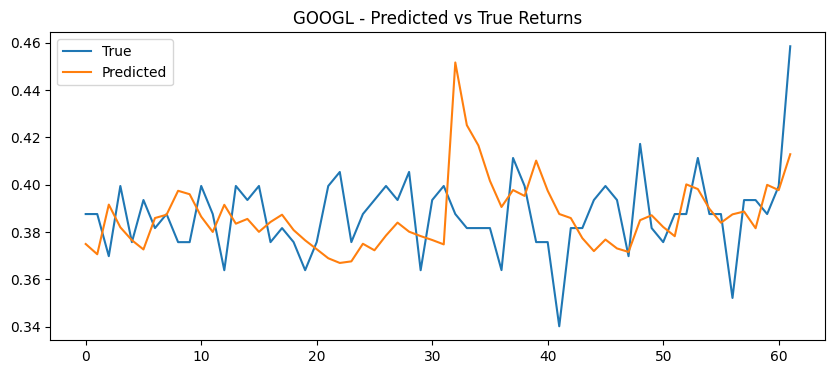

In [39]:
# Predict and plot
y_pred = model.predict(X_val)

plt.figure(figsize=(10, 4))
plt.plot(y_val, label='True')
plt.plot(y_pred, label='Predicted')
plt.title(f'{ticker} - Predicted vs True Returns')
plt.legend()
plt.show()

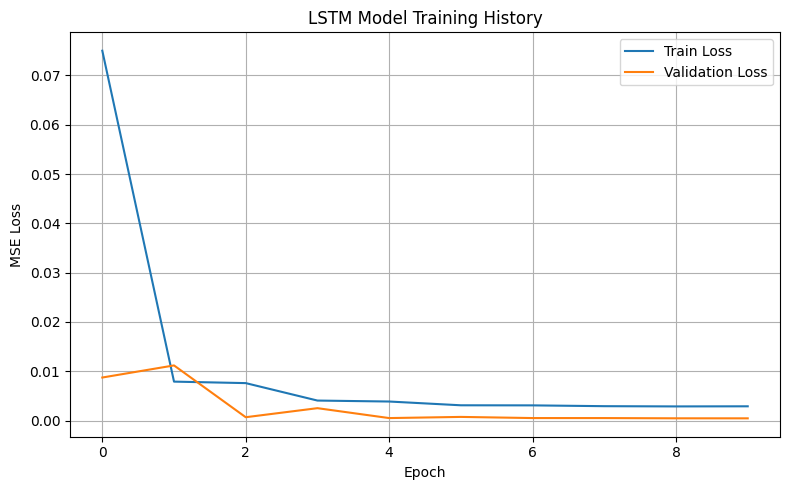

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Model Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()